# Single Cell QC

In [1]:
import warnings
warnings.filterwarnings("ignore")
import muon as mu
import numpy as np
import scanpy as sc
import scirpy as ir
import pandas as pd
from cycler import cycler
from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt
from mudata import MuData
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

2025-08-07 15:12:32.161502: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-07 15:12:32.169802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754593952.178969   23192 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754593952.181732   23192 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754593952.189151   23192 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
sc.logging.print_header()
np.random.seed(42)
import random
random.seed(42)

scanpy==1.10.2 anndata==0.11.3 umap==0.5.6 numpy==1.26.4 scipy==1.11.1 pandas==2.2.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


In [3]:
%pwd

'/ihome/ylee/yiz133/Code/Data processing'

In [7]:
%cd /ihome/ylee/yiz133/Code/data_EAE/anndata

/ihome/ylee/yiz133/Code/data_EAE/anndata


## Importing Yutong cell annotation data

In [8]:
# import pandas as pd
# metadata_paths = {
#     "CNS": "CNS_cell_type_annotation.csv",
#     "SPL": "Spleen_cell_type_annotation.csv"
# }

# # Read metadata files
# metadata_list = []
# for tissue, path in metadata_paths.items():
#     meta = pd.read_csv(path, index_col=0)  # Ensure the first column is treated as the index

#     # Extract run number from the index (barcode) → `_1` means "0516", `_2` means "0605"
#     meta["run_num"] = meta.index.to_series().str.split("_").str[-1].map({"1": "0516", "2": "0605"})

#     # Create the correct barcode format: "AAACCAAAGGGGAGCT-1_CNS_0605"
#     meta["barcode"] = meta.index.to_series().str.replace("_1", "", regex=False).str.replace("_2", "", regex=False)
#     meta["barcode"] = meta["barcode"] + "_" + meta["run_num"] + "_" + tissue

#     metadata_list.append(meta)

# # Combine metadata from both CNS and Spleen
# metadata = pd.concat(metadata_list, ignore_index=False)  # Keep original index

# # Merge metadata with `mdata.obs`
# mdata.obs = mdata.obs.merge(metadata, left_index=True, right_on="barcode", how="left")

# # Set the index to the barcode column for consistency
# mdata.obs.set_index("barcode", inplace=True)


### direct load data

In [116]:
mdata = mu.read("0605_SPL_DE_top4000.h5mu")

In [117]:
# exclude 2D2 transfer samples
# mdata = mu.read("common_cells_top2000Genes.h5mu")

# selected_samples_id = ["CMO301", "CMO302", "CMO318", "CMO325", "CMO323"]
# selected_date = ["0516"]
# selected_tissue = ["CN"]

# mdata = mdata[~ mdata.mod["gex"].obs["date"].isin(selected_date)]

# mdata = mdata[mdata.mod["gex"].obs["tissue"].isin(["SP"]) ]

# mdata = mdata[~ mdata.obs["manual_cell_type"].isin(["multiplet"])]

# mdata

In [118]:
mdata = mdata[:, ~mdata.var_names.str.startswith('mt')].copy()
mdata

MuData object with n_obs × n_vars = 31620 × 4000
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample'
  2 modalities
    gex:	31620 x 4000
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'log1p', 'pca'
      obsm:	'X_pca'
      varm:	'PCs'
    airr:	31620 x 0
      obsm:	'airr'

In [119]:
# del mdata["gex"].obs["leiden"]
# for col in ['leiden', 'pca', 'umap', 'leiden_colors']:
#     del mdata["gex"].uns[col]

In [120]:
# exclude multiples and myloids
mdata_all = mdata.copy()
mdata["gex"].obs["manual_cell_type"] = mdata.obs["manual_cell_type"]

# in_group = mdata["gex"].obs["manual_cell_type"].isin(["CD8+ T"])
# "CD4+ T","Treg","CD4+ Th17"
# mdata = mdata[in_group]
mdata

MuData object with n_obs × n_vars = 31620 × 4000
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample'
  2 modalities
    gex:	31620 x 4000
      obs:	'mouse_id', 'date', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'manual_cell_type'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'hvg', 'log1p', 'pca'
      obsm:	'X_pca'
      varm:	'PCs'
    airr:	31620 x 0
      obsm:	'airr'

In [121]:
sc.pp.pca(mdata["gex"], svd_solver="arpack", n_comps=20)

computing PCA
    with n_comps=20
    finished (0:00:02)


computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:07)
computing UMAP
    finished (0:00:27)
running Leiden clustering
    finished (0:00:02)


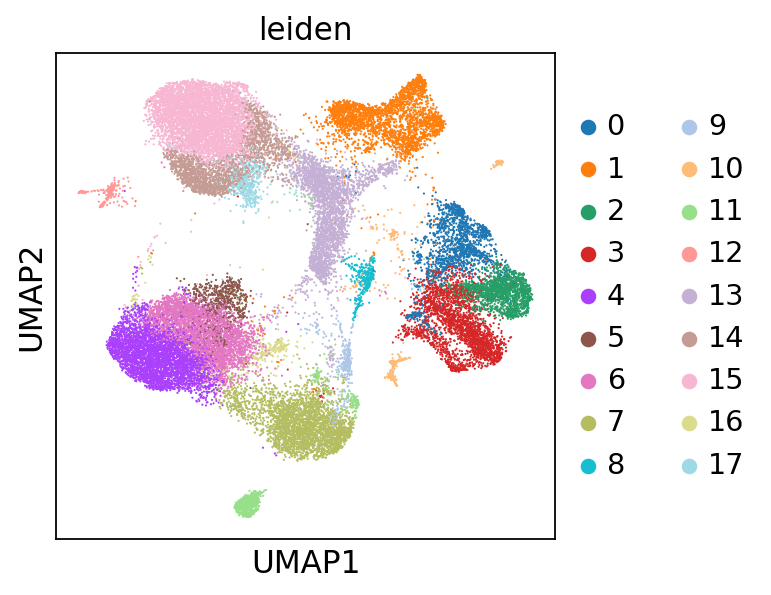

In [122]:
sc.pp.neighbors(mdata["gex"], n_neighbors = 50)
sc.tl.umap(mdata["gex"], min_dist=0.5, spread= 5.0)

sc.tl.leiden(mdata["gex"], resolution = 1.2, n_iterations=-1, flavor = 'igraph')
sc.pl.umap(mdata["gex"], color=["leiden"])

In [123]:
mdata["gex"].obs['manual_cell_type'] = mdata.obs['manual_cell_type']

# mdata["gex"].obs['manual_cell_type'] = mdata["gex"].obs['manual_cell_type'].cat.add_categories(["CD4+ Th17"])

# mdata["gex"].obs['manual_cell_type'][mdata["gex"].obs['leiden']=='7'] = 'CD4+ Th17'

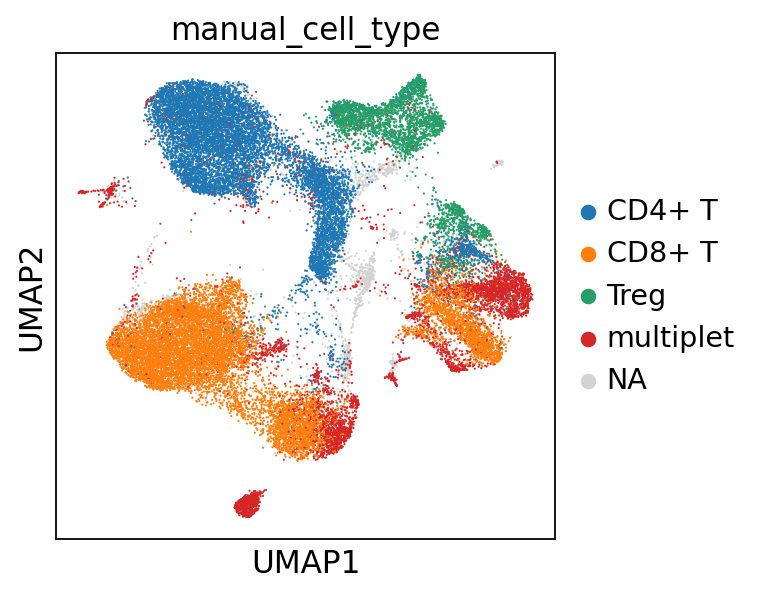

In [124]:
mdata["gex"].obs["manual_cell_type"] = mdata["gex"].obs["manual_cell_type"].cat.remove_unused_categories()
sc.pl.umap(mdata["gex"], color=["manual_cell_type"])

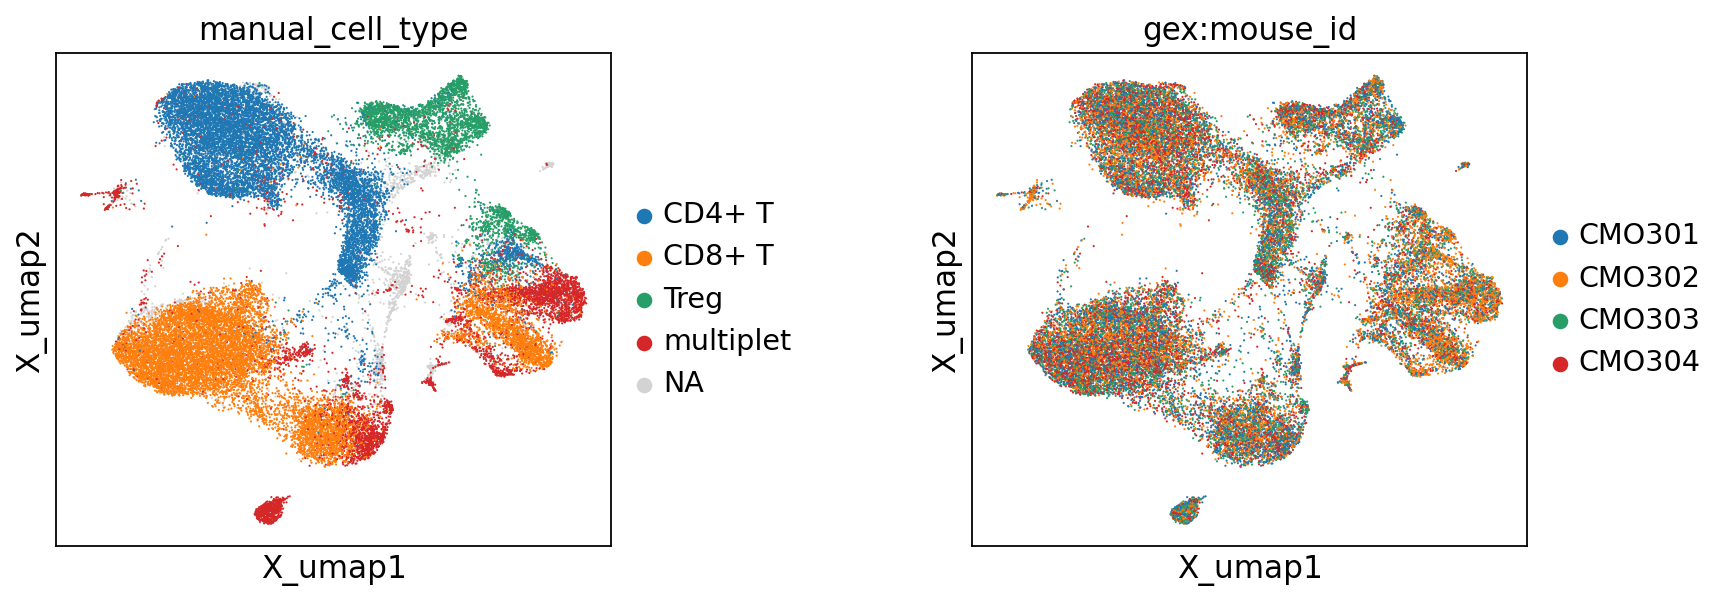

In [125]:
mu.pl.embedding(mdata, basis="gex:umap", color=['manual_cell_type', 'gex:mouse_id'], wspace = 0.5)

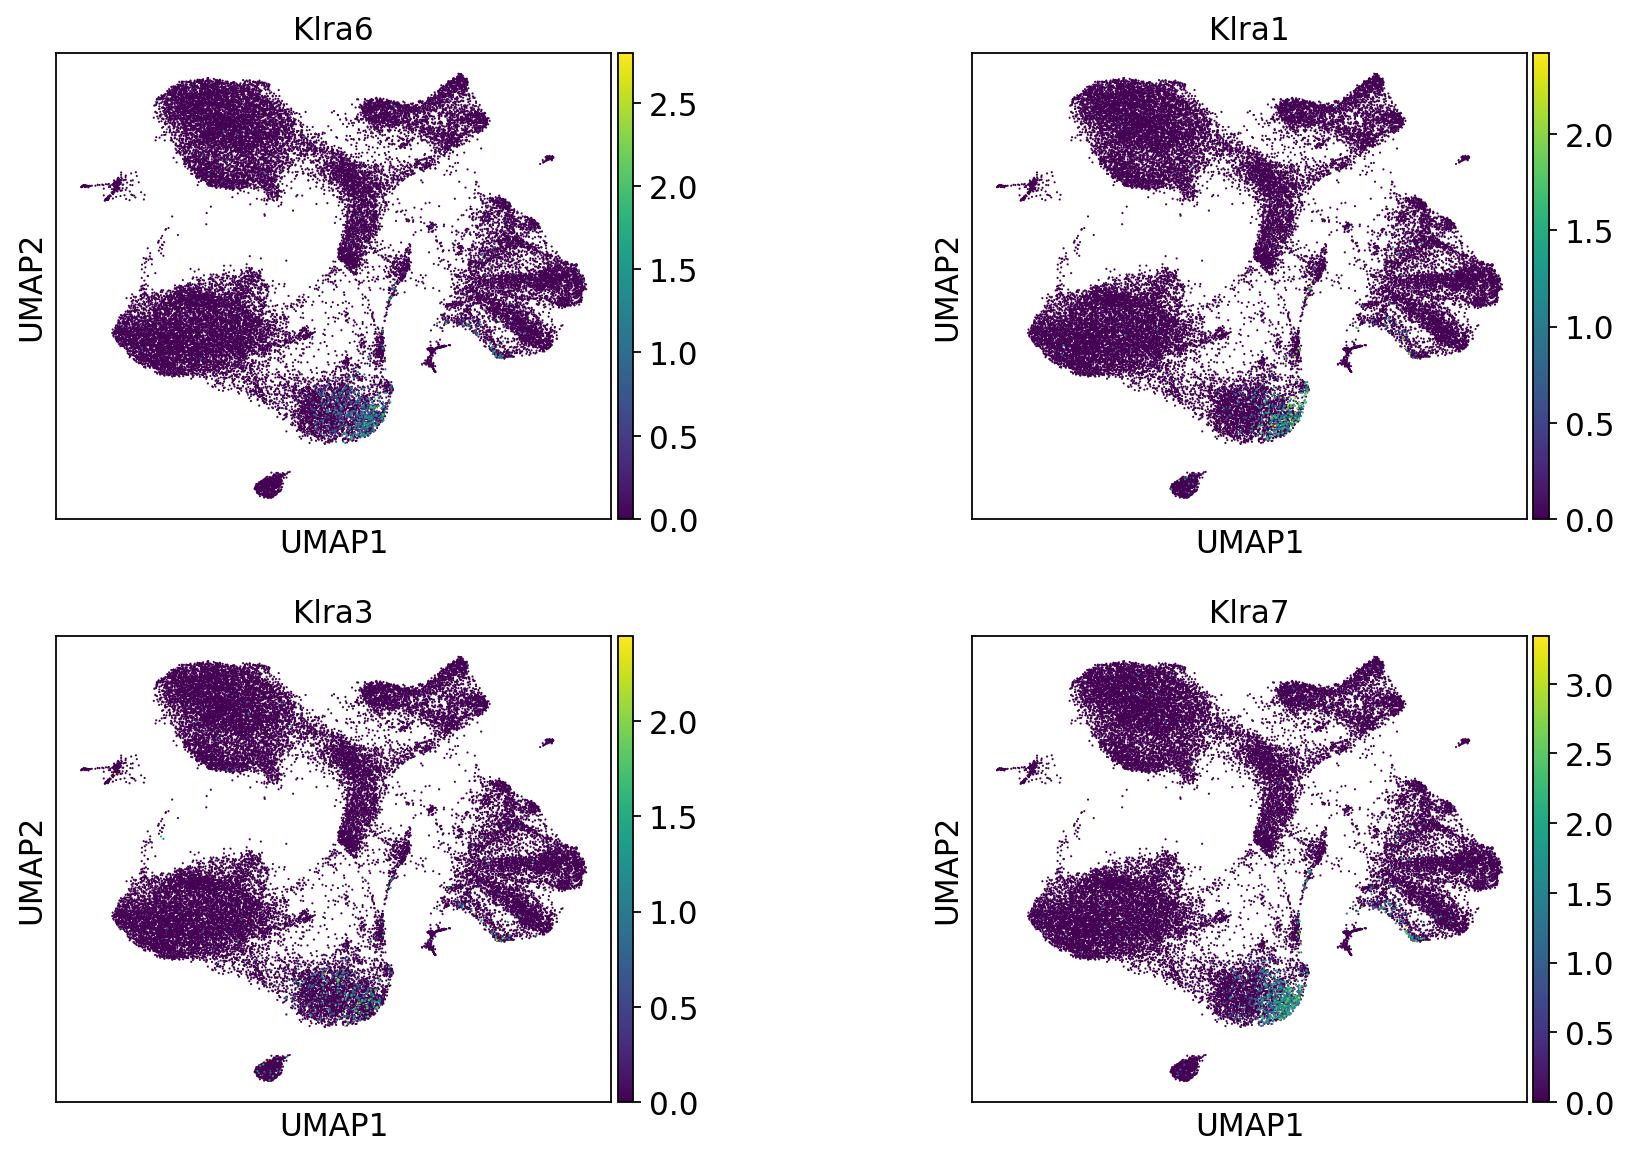

In [126]:
Kir_famili = ['Klra6', 'Klra1', 'Klra3', 'Klra7']
markers_in = []
for i in Kir_famili:
    if i in mdata["gex"].var_names:
        markers_in.append(i) 
markers_in

mu.pl.embedding(mdata["gex"], basis="umap", color= markers_in,  wspace = 0.5, ncols=2, vmin=0)

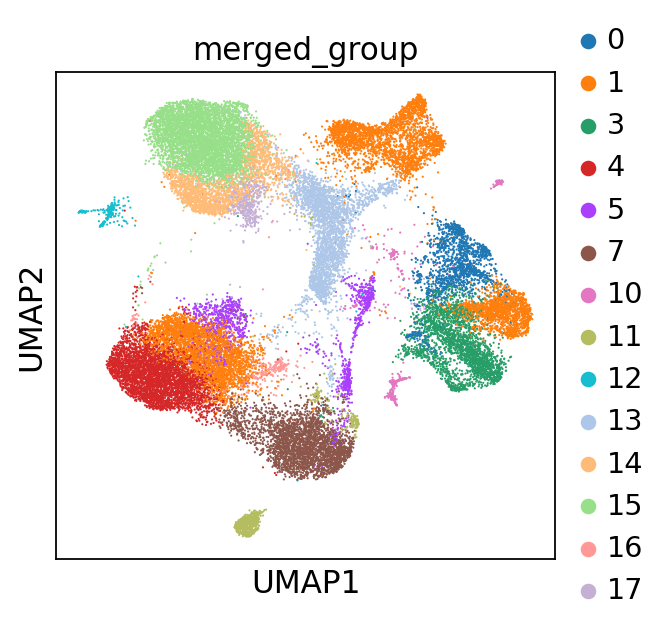

In [127]:
# List of clonotypes to analyze
mdata["gex"].obs["merged_group"] = mdata["gex"].obs["leiden"]

mdata["gex"].obs["merged_group"][mdata["gex"].obs["leiden"].isin(['1','2','6'])] = '1'
mdata["gex"].obs["merged_group"][mdata["gex"].obs["leiden"].isin(['5','8','9'])] = '5'

mdata["gex"].obs["merged_group"] = mdata["gex"].obs["merged_group"].cat.remove_unused_categories()

sc.pl.umap(mdata["gex"], color=["merged_group"])

In [128]:
# mdata["gex"].obs["manual_cell_type"] = mdata["gex"].obs["manual_cell_type"].cat.remove_unused_categories()
# sc.pl.umap(mdata["gex"], color=["manual_cell_type"])

# DEA among clusters

ranking genes
    finished (0:00:04)
    using 'X_pca' with n_pcs = 20
Storing dendrogram info using `.uns['dendrogram_leiden']`


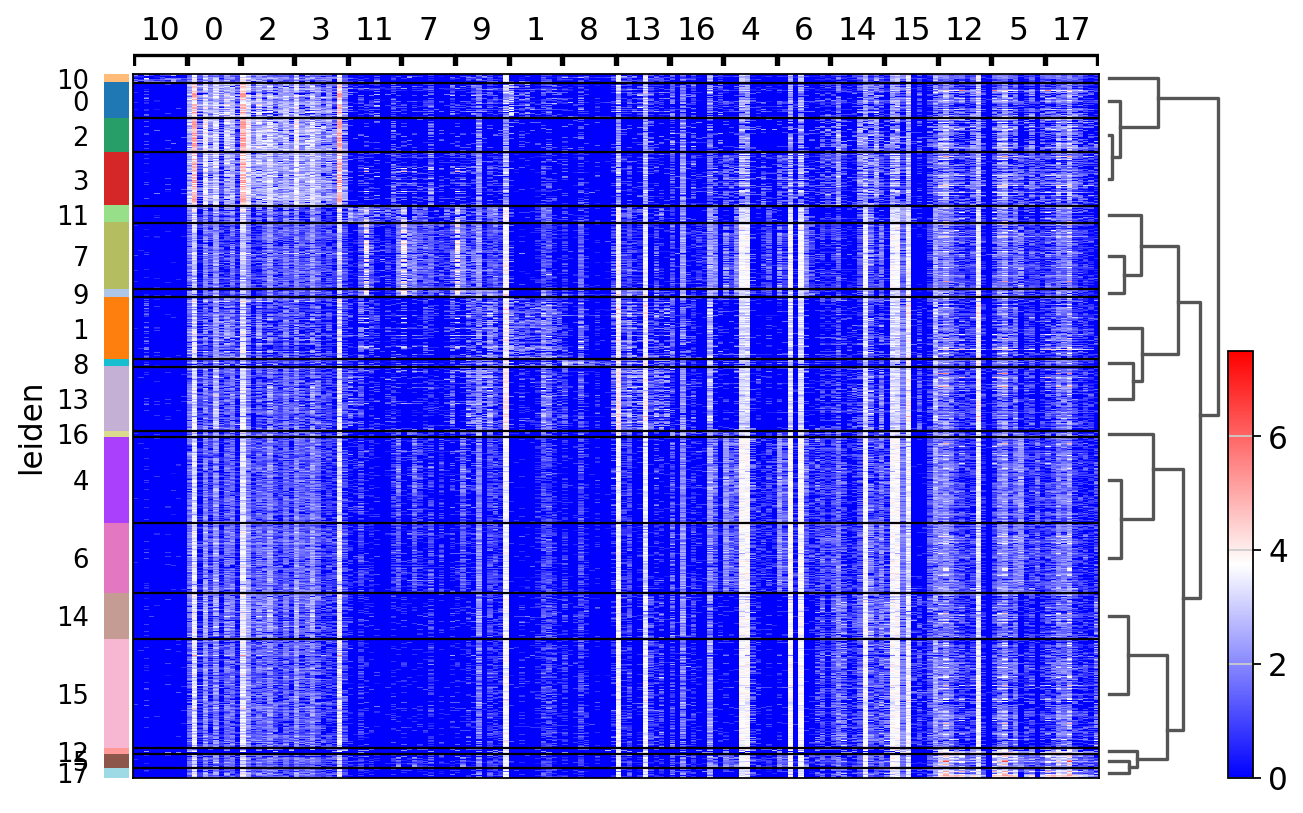

In [129]:
sc.tl.rank_genes_groups(mdata["gex"], groupby ="leiden", method="wilcoxon")

sc.pl.rank_genes_groups_heatmap(mdata["gex"], groupby = "leiden", 
                                n_genes=10, cmap='bwr',)



In [131]:
top_gene_leiden_score = mdata["gex"].uns['rank_genes_groups']['scores'][0:20].tolist()
com_genes_score = pd.DataFrame(top_gene_leiden_score)
com_genes_score

0          1          2          3          4          5   \
0   51.446087  68.676987  61.223434  68.362396  77.847374  32.578491   
1   49.226143  64.235237  60.689297  64.134789  71.128189  32.157970   
2   48.339306  60.011913  55.679466  63.505260  52.198322  31.283890   
3   48.056324  58.797836  54.294235  63.239048  50.084488  31.255943   
4   47.573555  53.399296  52.709934  60.509411  40.250557  31.185076   
5   47.182304  50.799034  49.100441  60.128059  30.915266  27.323814   
6   47.102024  50.761059  48.823219  59.729996  27.250612  26.571215   
7   46.801792  50.574482  48.760056  59.713245  26.210119  25.989918   
8   46.435688  48.897728  47.686047  58.567356  25.935390  25.797724   
9   44.805729  48.446068  47.050522  58.050785  25.661398  23.778973   
10  44.639114  44.574833  46.786800  57.947460  24.411570  21.519743   
11  44.150478  39.613239  46.564903  57.548988  24.259060  16.929317   
12  43.764606  39.381878  46.399513  57.318371  21.802568  14.748621   
13  42.190990  38.515160  46.127213  56.737442  21.759108  13.481084   
14  42.029041  38.085735  45.509094  55.118725  19.046465  11.617600   
15  41.315277  37.809776  45.502007  54.801182  18.582081  11.455734   
16  41.114704  37.430130  45.176388  53.945602  18.012909  10.748018   
17  40.938889  36.257053  45.165051  53.919559  16.917521  10.481490   
18  39.941395  36.238674  44.963207  53.761501  15.051607  10.282352   
19  39.399895  35.440254  43.347305  53.411655  14.642336   9.519607   

           6          7          8          9          10         11  \
0   62.695377  79.502129  31.414270  29.307365  29.282461  45.288273   
1   50.133068  76.590172  31.207935  29.255436  26.606487  39.637466   
2   41.169212  67.666611  30.951048  24.729227  24.945084  37.028084   
3   40.097469  61.280106  30.836021  24.646126  22.652052  36.483925   
4   40.065117  60.573494  30.326664  23.088985  21.757324  35.644562   
5   36.064651  52.731865  30.225924  23.053543  21.357317  35.318836   
6   35.178493  50.310879  29.875883  22.851873  21.061781  33.241150   
7   32.568882  49.384178  29.695778  22.510937  20.660639  32.096981   
8   32.492764  48.686611  28.093935  22.212017  20.604540  31.452333   
9   31.213301  47.996506  27.593735  21.505156  20.410292  31.321163   
10  30.544094  45.724819  27.482246  19.441019  19.551878  30.672972   
11  29.922312  45.105999  27.369465  19.060778  19.507948  28.048662   
12  29.915154  44.523392  27.367567  18.728069  19.385620  27.344545   
13  29.588873  43.170429  27.341551  18.501410  19.092485  25.596081   
14  28.542007  43.146523  27.022541  18.454414  18.508060  24.916033   
15  26.984875  41.866745  26.846008  18.450544  18.313593  24.835672   
16  26.911606  40.523762  26.657824  18.342930  17.935575  24.388950   
17  25.121643  39.924892  26.642401  17.687717  17.724808  24.080114   
18  24.459045  37.616180  26.465109  17.248850  17.706541  23.708427   
19  23.924860  36.519714  26.207144  17.217798  17.614273  23.524326   

           12         13         14         15         16         17  
0   23.613247  57.272518  30.978065  57.154961  20.732477  30.531858  
1   23.383768  55.374577  28.131712  52.875740  19.172617  29.881968  
2   17.277092  52.686951  27.491434  51.075768  18.495865  29.407961  
3   14.976269  48.073956  25.249109  34.277760  16.820539  28.652706  
4   13.285430  47.661945  24.863720  33.139149  16.520311  28.368105  
5   11.691381  46.888218  23.794476  33.052830  15.550193  24.335333  
6   10.767477  45.690327  23.576643  30.465242  14.213902  24.007235  
7    8.716403  44.189732  22.746334  29.016941  13.609410  23.951599  
8    8.014698  43.921135  22.416775  27.000103  13.179262  19.813961  
9    5.052495  40.521564  22.391935  24.655287  12.166514  14.992400  
10   5.036370  40.032497  22.217297  22.887890  11.649805  13.406842  
11   4.929562  38.458225  22.183113  20.856874  11.354056  10.421620  
12   4.843980  37.283936  20.999971  20.552515  11.187193   8.

ranking genes
    finished (0:00:01)


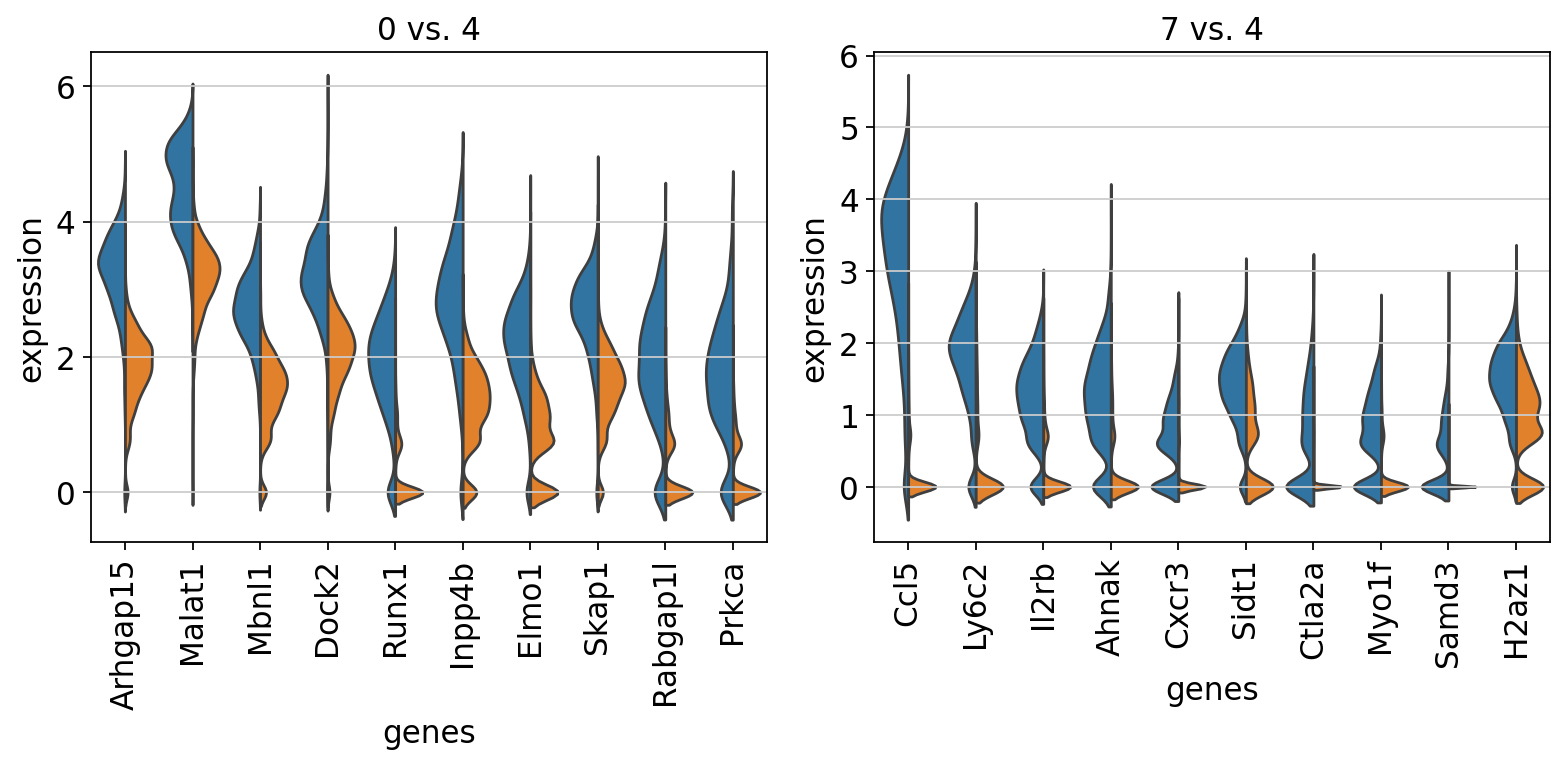

In [132]:
leiden_clusters = ['0','7']

sc.tl.rank_genes_groups(mdata["gex"], groupby ="merged_group", reference = '4',
                        groups = leiden_clusters, method="wilcoxon")

num_clonotypes = len(leiden_clusters)
num_cols = 2  # Number of columns in the figure
num_rows = int(np.ceil(num_clonotypes / num_cols))  # Number of rows based on total clonotypes

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))  
axs = axs.flatten()  # Flatten in case of multiple rows

# Generate violin plots for each clonotype
for ct, ax in zip(leiden_clusters, axs):
    sc.pl.rank_genes_groups_violin(mdata["gex"], groups=[ct], n_genes=10, ax=ax, show=False, strip=False)

# Remove any unused subplots
for i in range(len(leiden_clusters), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

### DAE in mergerd groups

ranking genes
    finished (0:00:00)
    using 'X_pca' with n_pcs = 20
Storing dendrogram info using `.uns['dendrogram_merged_group']`


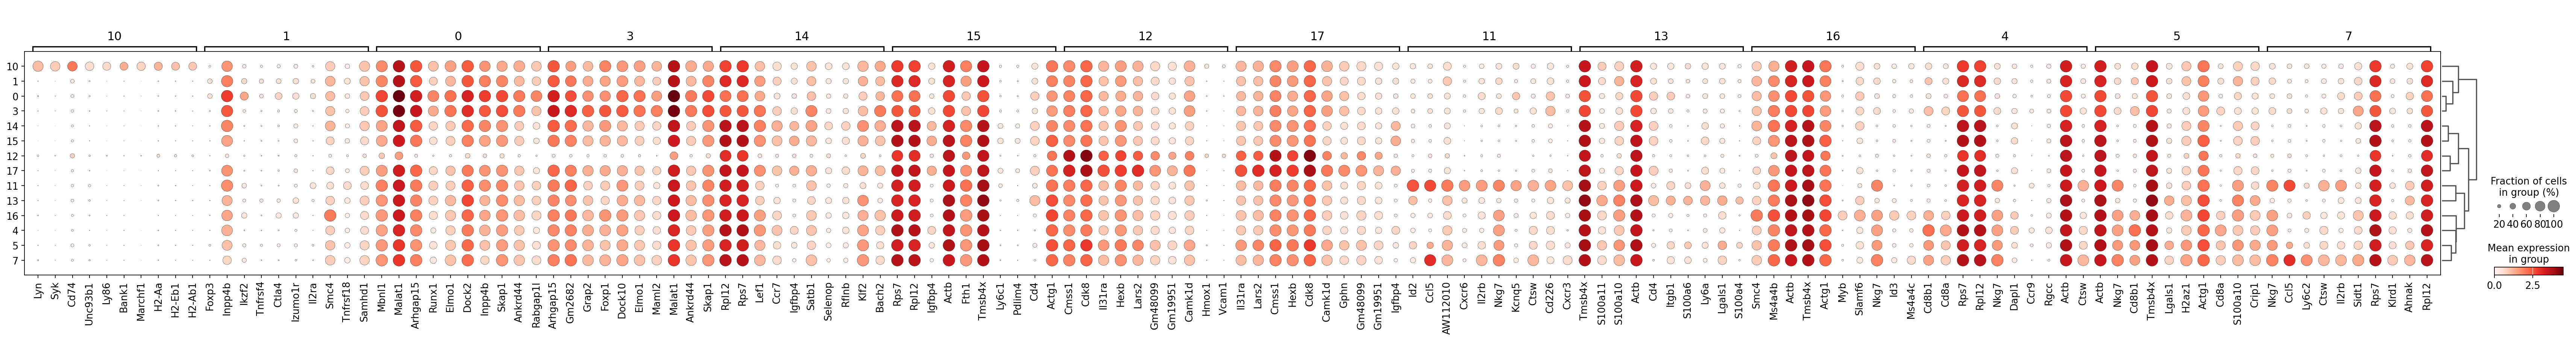

In [133]:
merged_clusters = ['0','7']

# groups = merged_clusters,
sc.tl.rank_genes_groups(mdata["gex"], groupby = "merged_group")
    
sc.pl.rank_genes_groups_dotplot(mdata["gex"], groupby = "merged_group", n_genes=10)
# sc.pl.dotplot(mdata["gex"], groupby = "merged_group",  genes=10)

 # groupby = "merged_group", groups = merged_clusters,

ranking genes
    finished (0:00:00)


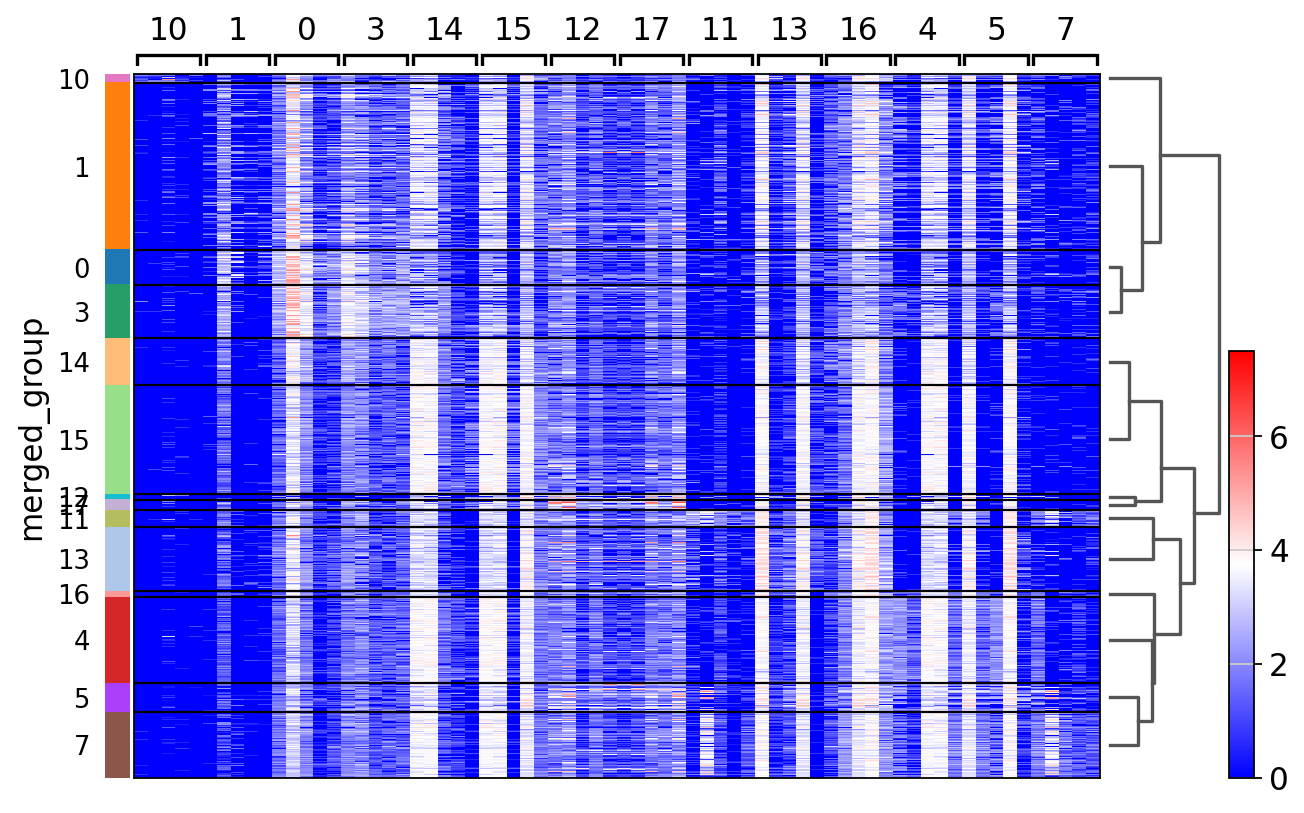

In [134]:
merged_clusters = ['0','7']
sc.tl.rank_genes_groups(mdata["gex"], groupby = "merged_group")
# groups = merged_clusters

sc.pl.rank_genes_groups_heatmap(mdata["gex"], groupby = "merged_group",
                                n_genes=5, cmap='bwr',)

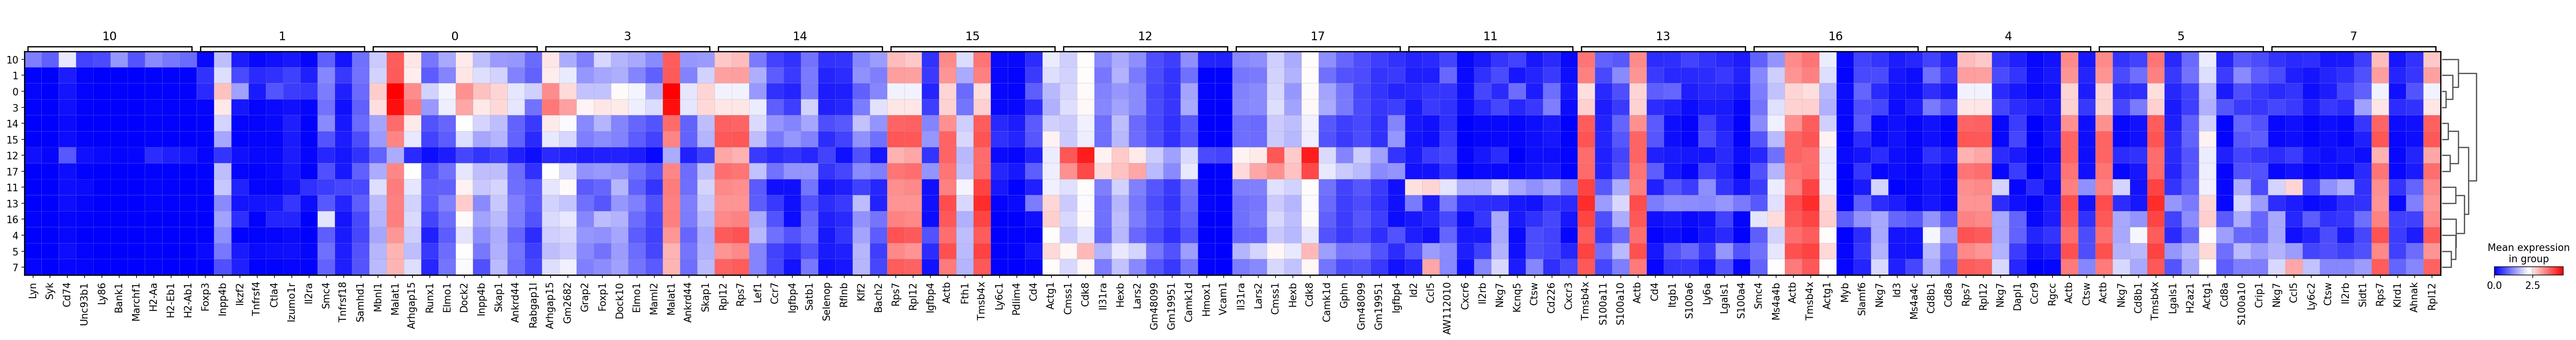

In [135]:
# logfold change
sc.pl.rank_genes_groups_matrixplot(mdata["gex"], groupby = "merged_group",
                                n_genes=10, cmap='bwr')

In [136]:
a = mdata["gex"].uns['rank_genes_groups']['names'][0:20].tolist()
com_genes = pd.DataFrame(a)
# com_genes

In [137]:
# sc.pl.dotplot(mdata["gex"], var_names=['Cd4', 'Runx1'], groupby='leiden')

# DEA among annotated cell types

ranking genes
    finished (0:00:03)
    using 'X_pca' with n_pcs = 20
Storing dendrogram info using `.uns['dendrogram_manual_cell_type']`


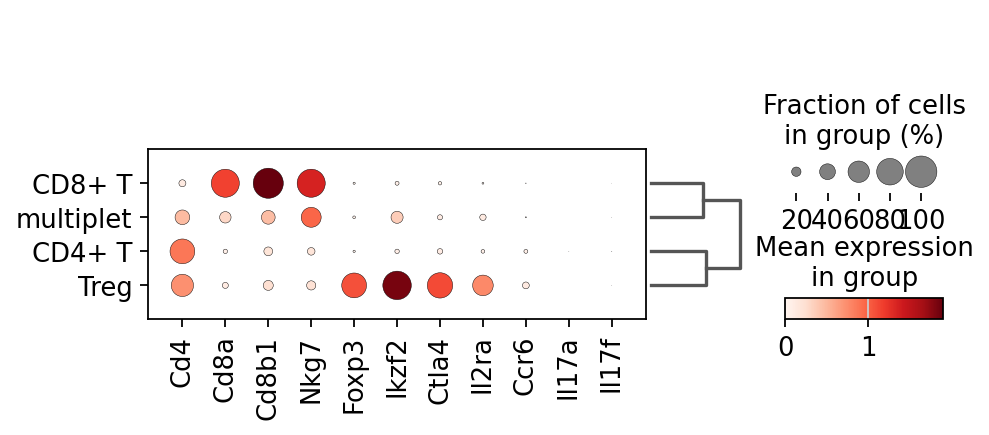

In [139]:
cell_types = ['CD4+ T', 'CD8+ T', 'Treg']
# , 'CD4+ Th17'
mdata.obs['manual_cell_type'] = mdata["gex"].obs['manual_cell_type']

sc.tl.rank_genes_groups(
        mdata["gex"],
        "manual_cell_type",
        groups = cell_types,
        reference= "rest",
        method="wilcoxon"
    )

sc.pl.rank_genes_groups_dotplot(mdata["gex"], groupby ="manual_cell_type", 
                                   var_names=["Cd4", "Cd8a", "Cd8b1", "Nkg7","Foxp3", "Ikzf2", "Ctla4", "Il2ra", "Ccr6", 'Il17a', 'Il17f'], )

In [142]:
top_gene_cellTypes = mdata["gex"].uns['rank_genes_groups']['names'][0:10].tolist()
# 'scores', 'logfoldchanges', 'pvals', 'pvals_adj', 'pts'
com_genes = pd.DataFrame(top_gene_cellTypes)
com_genes

0        1         2
0     Cd4    Cd8b1     Ikzf2
1  Tmsb4x     Cd8a     Foxp3
2    Ly6a     Nkg7     Ctla4
3  Cd40lg  Gm44174   Izumo1r
4    Fth1    Klrd1  Rabgap1l
5    Actb     Ctsw   Tnfrsf4
6  Igfbp4  Fam241a     Il2ra
7   Rpl12     Rps7  Tnfrsf18
8   Rflnb    Sidt1      Nrp1
9    Ass1   Epsti1      Capg

#### mini subset

In [152]:
# sc.tl.score_genes(mdata['gex'], gene_list=com_genes.iloc[:,0], score_name='Cd4_score')
# sc.tl.score_genes(mdata['gex'], gene_list=com_genes.iloc[:,1], score_name='Cd8_score')
# sc.tl.score_genes(mdata['gex'], gene_list=com_genes.iloc[:,2], score_name='Treg_score')

# mdata_pupil = mdata[:, mdata['gex'].var_names.isin(com_genes.values.flatten())].copy()
# mdata_pupil

# N = 50

# # Get top N cell indices for each obs column
# top_obs1 = mdata_pupil['gex'].obs.sort_values('Cd4_score', ascending=False).head(N).index
# top_obs2 = mdata_pupil['gex'].obs.sort_values('Cd8_score', ascending=False).head(N).index
# top_obs3 = mdata_pupil['gex'].obs.sort_values('Treg_score', ascending=False).head(N).index

# # Combine and remove duplicates (if any)
# top_cells = pd.Index(top_obs1.union(top_obs2).union(top_obs3))

# # Subset mdata to those cells
# mdata_top = mdata_pupil[top_cells].copy()

# # Extract gene expression matrix to DataFrame
# # Assume you want raw counts or normalized expression
# df_genes = pd.DataFrame(
#     mdata_top['gex'].X.toarray(),
#     index= mdata_top.obs_names,
#     columns= mdata_top.var_names
# )

# df_genes.to_csv('mini_scRNA.csv')

computing score 'Cd4_score'
    finished (0:00:00)
computing score 'Cd8_score'
    finished (0:00:00)
computing score 'Treg_score'
    finished (0:00:00)


### heat map

In [ ]:
sc.pl.rank_genes_groups_heatmap(mdata["gex"], groupby ="manual_cell_type", n_genes=10, cmap='bwr')

In [ ]:
#### remove unormal genes ###
genes_to_remove = ['Tmsb4x', 'Actb', 'Rpl12', 'Rps7','Fth1', 'Left1']
mask = ~mdata["gex"].var_names.isin(genes_to_remove)
adata_filtered = mdata["gex"][:, mask].copy()


In [ ]:
sc.tl.rank_genes_groups(
        adata_filtered,
        "manual_cell_type",
        groups = cell_types,
        reference= "rest",
        method="wilcoxon",
    )

sc.pl.rank_genes_groups_heatmap(adata_filtered, groupby ="manual_cell_type", n_genes=10, cmap='bwr')

In [ ]:
#### violin plot  #####
# num_plots = len(cell_types)
# num_cols = 2  # Number of columns in the figure
# num_rows = int(np.ceil(num_plots / num_cols))  # Number of rows based on total clonotypes

# # Create subplots
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 4))  
# axs = axs.flatten()  # Flatten in case of multiple rows

# # Generate violin plots for each clonotype
# for ct, ax in zip(cell_types, axs):
#     sc.pl.rank_genes_groups_violin(mdata["gex"], groups=[ct], n_genes=25, ax=ax, show=False, strip=False)

# # Remove any unused subplots
# for i in range(len(cell_types), len(axs)):
#     fig.delaxes(axs[i])

# plt.tight_layout()
# plt.show()
    

In [ ]:
# ir.pp.index_chains(mdata)
# ir.tl.chain_qc(mdata)

In [ ]:
# mu.pl.embedding(mdata, basis="gex:umap", color=['Cd4'], wspace = 0.5, ncols=2)

# DAE for cell states

In [ ]:
cell_state_Yutong = ['Isg15', 'Gbp2', 'Ifih1', 'Icos', 'Cd69', 'Cd28', 'Pdcd1', 'Lag3', 'Ccr7', 'Sell']

In [ ]:
sc.tl.rank_genes_groups(
        mdata["gex"],
        "leiden",
        # groups = cell_state_Yutong,
        reference= "rest",
        method="wilcoxon"
    )

sc.pl.rank_genes_groups_dotplot(mdata["gex"], groupby ="leiden", 
                                   var_names=cell_state_Yutong, )

In [ ]:
cluster_state = {
    "2": "Exhuasted",
    "1": "Activated",
    "0": "Activated",
    "7": "IFN stimulated",
    "5": "Memory/Naive",
    "9": "Memory/Naive",
    "8": "Memory/Naive",
    "10": "Memory/Naive",    
    "6": "Memory/Naive",
    "11": "Memory/Naive",
    "3": "Memory/Naive", 
    "4": "Memory/Naive",
    
}

In [ ]:
mdata["gex"].obs["cell_state"] = mdata["gex"].obs["leiden"].map(cluster_state)
sc.pl.umap(mdata["gex"], color=["leiden", "cell_state"])

In [ ]:
sc.pl.rank_genes_groups_dotplot(mdata["gex"], groupby ="cell_state", 
                                   var_names=cell_state_Yutong, )

### T cell subset markers

In [ ]:
target_genes = [gene for gene in mdata["gex"].var_names if gene.startswith("Lta")]
target_genes

In [ ]:
# markers for CD4+
# select from DEA

# set 1: human markers 
# <Reinvestigation of Classic T Cell Subsets and Identification of Novel Cell Subpopulations by Single-Cell RNA Sequencing>
# naive_markers = ['Ccr7', 'Lef1', "Sell"]
# cd4_mem_markers = ['Tnfrsf4', 'Timp1', "Usp10"]
# cd8_Eff_Mem_markers = ['Cd45ra', 'Fgfbp2', "Gzmh", "Gzmb"]
# Mait_markers = ["Klrb1", "Ncr3", "Zbtb16", 'Rorc']


# set 2: mouse markers
# <Single-Cell RNA Sequencing of the T Helper Cell Response to House Dust Mites Defines a Distinct Gene Expression Signature in Airway Th2 Cells>
Th2_markers = ['Gata3', 'Il13', "Il5", "Il1rl1", "Plac8", "Igfbp7"]
Th1_markers = ['Cxcr3', 'Ccl5', "Tbx21"]
Th17_markers = ['Ccr6']
Activated_markers = ['Tcf7', 'S1pr1', "Trat1", "Tmem176a"]
Treg_markers = ["Foxp3", "Ctla4", "Il10", "Klrg1", "Folr4", "Il2ra"]

sorting_marker = ["Cd3", "Cd4", "Cd44", "St2", "Cd25"]

In [ ]:
markers_in = []
for i in cell_state_Yutong:
    if i in adata_filtered.var_names:
        markers_in.append(i) 

mu.pl.embedding(mdata, basis="gex:umap", color= markers_in, wspace = 0.5, ncols=2, vmin=0)

In [ ]:
# from top DAE
mu.pl.embedding(mdata, basis="gex:umap", color=com_genes.iloc[-4:-1,0], wspace = 0.5, ncols=2)

In [ ]:
# in_mem_cluster = mdata["gex"].obs["leiden"].isin([ "0", "1"])

# mdata.obs["manual_cell_type"][in_mem_cluster] = mdata.obs["manual_cell_type"] + "_mem"
# mdata.obs["manual_cell_type"][in_mem_cluster] = mdata.obs["manual_cell_type"][in_mem_cluster]+ "_mem"

# for i in range(len(mdata)):
#     if mdata.obs["manual_cell_type"][i][-4:] == "_mem":
#         mdata.obs["manual_cell_type"][i] = mdata.obs["manual_cell_type"][i][:-4]

In [ ]:
mu.pl.embedding(mdata, basis="gex:umap", color=['manual_cell_type','gex:tissue'], wspace = 0.5)

In [ ]:
# another ploting commd
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
# mu.pl.embedding(mdata, basis="gex:umap", color=["Cd3e"], ax=ax0, show=False)
# mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

In [ ]:
# mdata.write("0605_SPL_Clustered_GEX_Top2000.h5mu")

# subset in CD4

In [ ]:
 # mdata[mdata.mod["gex"].obs["tissue"].isin(["SP"]) ]

In [ ]:
cd4_set = mdata[mdata.obs["manual_cell_type"].isin(["CD4+ T", "CD4+ T_mem"])]

In [ ]:
cd4_set.obs["manual_cell_type"].value_counts()

In [ ]:
sc.pp.pca(cd4_set["gex"], svd_solver="arpack", n_comps=20)

In [ ]:
sc.pp.neighbors(cd4_set["gex"], n_neighbors = 20)
sc.tl.umap(cd4_set["gex"], min_dist=0.5, spread=1.0)
sc.tl.leiden(cd4_set["gex"], resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(cd4_set["gex"], color=["leiden", "manual_cell_type"])

In [ ]:
# sc.pp.neighbors(cd4_set["gex"], n_neighbors = 50)
# sc.tl.umap(cd4_set["gex"], min_dist=0.5, spread=5.0)
# sc.tl.leiden(cd4_set["gex"], resolution = 1, n_iterations= -1, flavor = 'igraph')
# sc.pl.umap(cd4_set["gex"], color=["leiden", "manual_cell_type"])


In [ ]:
# leiden_groups = list(set(cd4_set["gex"].obs["leiden"])
L = int(max(cd4_set["gex"].obs['leiden']))
leiden_groups = [str(x) for x in range(L+1)]

sc.tl.rank_genes_groups(
        cd4_set["gex"],
        "leiden",
        groups = leiden_groups,
        reference= "rest",
        method="wilcoxon"
    )

In [ ]:
# Dynamically determine the number of rows/columns for subplots
sc.tl.dendrogram(cd4_set["gex"], groupby='leiden',)
sc.pl.rank_genes_groups_matrixplot(cd4_set["gex"], groupby='leiden', n_genes=10, cmap='bwr')

In [ ]:
target_genes = [gene for gene in cd4_set["gex"].var_names if gene.startswith("Tbx21")]
target_genes

In [ ]:
# set 1: human markers
# <Current annotation strategies for T cell phenotyping of single-cell RNA-seq data>
# Th1_markers = ['Ccl5', 'Ccr1', 'Cxcr3', 'Tnfa', 'Cd3', 'Il2']
# Th2_markers = ['Cd3', 'Ccr3', 'Ccr8', 'Gata3', 'Il5', 'Il4']
# Th17_markers = ['Il17a', 'Il17f', 'Il17', 'Il7r', 'Il5', 'Il4']
# cd4_markers = ['Ly6a', 'Cd40lg']

# set 2: mouse markers
# <Single-Cell RNA Sequencing of the T Helper Cell Response to House Dust Mites Defines a Distinct Gene Expression Signature in Airway Th2 Cells>
Th1_markers = ['Tbx21', 'Ccl5', 'Cxcr3', 'Ifng', 'Gzmk', "Il2", "Lta", "Tnf", 'Il12rb2']
# not exclusive genes: 'Stat4', 'Stat1', 'Ms4a4b', 
Th2_markers = ['Gata3', 'Il13', 'Il1rl1', 'Plac8', 'Il5', 'Igfbp7', "Il4", "Ccr4", "Ccl17", "Stat6"]
activated_markers = ['Tcf7', 'S1pr1', 'Trat1', 'Klf2', 'Tmem176a', 'Tmem176b']
Treg_markers = ['Foxp3', 'Ctla4', 'Il2ra', "Ikzf2", 'Il10', 'Klrg1',  'Folr4', "Cd39"]
Th17_markers = ['Rorc', 'Il17a', 'Il17f', 'Il23r', 'Ccr6', 'Itgae', 'Furin', 'Ctsh', "Il21", "Stat3", "Cd40lg"]

#


In [ ]:
markers_in = []
for i in Th2_markers:
    if i in cd4_set["gex"].var_names:
        markers_in.append(i) 
markers_in

mu.pl.embedding(cd4_set["gex"], basis="umap", color= markers_in,  wspace = 0.5, ncols=2, vmin=0)

In [ ]:
top_gene_by_type = cd4_set["gex"].uns['rank_genes_groups']['names'][0:20].tolist()
com_genes = pd.DataFrame(top_gene_by_type)
com_genes

# keep subsetting

In [ ]:
cd4_subset1 = cd4_set["gex"][cd4_set["gex"].obs["leiden"].isin(["0","1","4"])]

In [ ]:
sc.pp.pca(cd4_subset1, svd_solver="arpack", n_comps=20)

In [ ]:
sc.pp.neighbors(cd4_subset1, n_neighbors = 20)
sc.tl.umap(cd4_subset1, min_dist=0.2, spread=2.0)
sc.tl.leiden(cd4_subset1, resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(cd4_subset1, color=["leiden", "manual_cell_type"])

In [ ]:
markers_in = []
for i in Treg_markers:
    if i in cd4_subset1.var_names:
        markers_in.append(i) 
markers_in

mu.pl.embedding(cd4_subset1, basis="umap", color= markers_in,  wspace = 0.5, ncols=2)

## compare with ref set

In [ ]:
cluster_data = []
# 'pvals_adj', 'pts'

top_L = 100
topGene_names = pd.DataFrame(cd4_set["gex"].uns['rank_genes_groups']['names'][0:top_L].tolist())
topGene_scores = pd.DataFrame(cd4_set["gex"].uns['rank_genes_groups']['scores'][0:top_L].tolist())
topGene_LF = pd.DataFrame(cd4_set["gex"].uns['rank_genes_groups']['logfoldchanges'][0:top_L].tolist())
topGene_pvals = pd.DataFrame(cd4_set["gex"].uns['rank_genes_groups']['pvals'][0:top_L].tolist())

metrics = ['gene', 'scores', 'avg_logFC', 'pvals']
metrics_df = [topGene_names, topGene_pvals, topGene_scores, topGene_LF]

clusters_list = []
for i in range(L+1):
    cluster_dict = {}
    for j in range(len(metrics)):
        cluster_dict[metrics[j]] = metrics_df[j].iloc[:,i]
    clusters_list.append(cluster_dict)


In [ ]:
%cd ../../../Data processing/data/ref_snRNA/1

In [ ]:
import pickle
with open('Cd4_p.pkl', 'rb') as file:
    cluster_metric_ref = pickle.load(file)
metric_selected = 'avg_logFC'
ref_types = len(cluster_metric_ref)

# cluster_metric_ref = pd.read_csv('Th17.csv')
# metric_selected = 'effect_size'
# ref_types = 1

In [ ]:
# intersect genes
corr_mat = np.zeros([L+1, ref_types])
common_gene_num = np.zeros([L+1, ref_types])

common_genes_L = []

for i in range(L+1):
    for j in range(ref_types):
        
        # multi tab
        ref_cluster = cluster_metric_ref[str(j+1)].loc[:, [metric_selected, 'gene']]
        # 'gene', 'scores', 'avg_logFC', 'pvals']
        
        # single tab
        # ref_cluster = cluster_metric_ref.loc[:, [metric_selected, 'gene']]
        
        n_genes = min(top_L, len(ref_cluster))
        ref_cluster = ref_cluster.sort_values(by= metric_selected, ascending=False)
        ref_cluster = ref_cluster.iloc[:n_genes]

        c1 = pd.DataFrame(clusters_list[i]).iloc[:n_genes, [0,2]]
        c2 = pd.DataFrame(ref_cluster)
        
        common_genes = pd.merge(c1, c2, on='gene', how='inner')
        corr_mat[i][j] = common_genes.iloc[:,1].corr(common_genes.iloc[:,2], method='kendall')
        common_gene_num[i][j] = len(common_genes)
        
        common_genes_L.append(common_genes)
    
pd.DataFrame(corr_mat)

In [ ]:
markers_in = common_genes_L[0]['gene'].to_list()
mu.pl.embedding(cd4_set["gex"], basis="umap", color= markers_in, wspace = 0.5, ncols=2)

In [ ]:
common_genes_L[0]

In [ ]:
common_genes_L[4]

In [ ]:
# top_gene_all = cd4_set["gex"].uns['rank_genes_groups']['names'].tolist()
# top_gene_all_df = pd.DataFrame(top_gene_all)

# search_gene = "Ccl5"
# mask = top_gene_all_df.isin([search_gene])

# matching_indices = top_gene_all_df.index[mask.any(axis=1)].tolist()

# print(matching_indices)

# batch effect


In [ ]:
mdata_ori = mu.read("common_GEX_TCR_QC_mdata.h5mu")
mdata_ori

In [ ]:
# exclude 2D2 transfer samples

selected_samples_id = ["CMO301", "CMO302", "CMO318", "CMO325", "CMO323"]
selected_date = ["0516"]
selected_tissue = ["CN"]

mdata = mdata_ori[~ (mdata_ori.mod["gex"].obs["mouse_id"].isin(selected_samples_id) & mdata_ori.mod["gex"].obs["date"].isin(selected_date))]

# positive select
# mdata = mdata[mdata.mod["gex"].obs["sample"].isin(["SPL_0605"]) ]
mdata

In [ ]:
# mdata.obs["sample"] = mdata.obs["sample"].cat.remove_unused_categories()
# mdata.obs["manual_cell_type"] = mdata.obs["manual_cell_type"].cat.remove_unused_categories()
# mdata.obs["celltype_sample"] = (
#     mdata.obs["manual_cell_type"].astype(str) + "_" + mdata.obs["sample"].astype(str)
# )

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(8,8))
# mu.pl.embedding(mdata_ori, basis="gex:umap", ax=ax0)

mask = mdata_ori['gex'].obs['tissue'] == 'SP'

mu.pl.embedding(mdata_ori, basis="gex:umap", color=['gex:mouse_id'], mask_obs=mask, ax=ax0)

In [ ]:
mdata["gex"].obs["mouse_id"].value_counts()

In [ ]:
import bbknn
bbknn.bbknn(mdata["gex"], batch_key="mouse_id", use_annoy=False)

In [ ]:
sc.tl.umap(mdata["gex"])

In [ ]:
mu.pl.embedding(mdata, basis="gex:X_umap", color = ["gex:mouse_id", "manual_cell_type"], wspace = 0.5)


In [ ]:
# alternative plot commmand


# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"wspace": 1})
# sc.pl.umap(mdata["gex"], color=["mouse_id"])
# mdata["gex"].obs["manual_cell_type"] = mdata.obs["manual_cell_type"]

# sc.pl.umap(mdata["gex"], color=["manual_cell_type"])


In [ ]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(mdata["gex"], resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(mdata["gex"], color=["leiden"])

In [ ]:
mdata["gex"].obs["leiden"]

# Save Filtered TCR table

In [ ]:
mdata = mu.read("common_GEX_TCR_mdata.h5mu")
mdata

In [ ]:
adata_tcr = mdata.mod['airr']
adata_tcr.obsm["airr"][0]

In [ ]:
meta_DF = ir.get.airr(adata_tcr, ["cdr3_aa", "consensus_count", "v_call", "j_call"] ,  ('VJ_1', 'VDJ_1'))

# , "high_confidence","productive"

# ('VJ_1', 'VDJ_1', 'VJ_2', 'VDJ_2'), 

meta_DF.iloc[0:10,:]

In [ ]:
meta_DF["VDJ_1_j_call"].value_counts()

In [ ]:
# meta_DF.to_csv('primary_TCR.csv', index=True)